# Major Points of Understanding

There are multiple variables in the dataset – Date, Open, High, Low, Close and volume.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.

High and Low represent the maximum and minimum price of the share for the day.

Volume is the number of shares bought or sold in the day

Another important thing to note is that the market is closed on weekends and public holidays.Notice the above table again, some date values are missing – 4/3/2015, 4/4/2015 and 4/5/2015. Of these dates, 3rd April 2015 was a public holiday due to the occasion of Good Friday, while 4th and 5th April were weekends

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data

# Importing the Libraries

In [8]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [10]:
df = pd.read_csv("E:Downloads/INR=X.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-27,71.320000,71.635002,71.320000,71.324997,71.324997,0
1,2020-01-28,71.654999,71.654999,71.178001,71.440002,71.440002,0
2,2020-01-29,71.230103,71.425003,71.168503,71.230400,71.230400,0
3,2020-01-30,71.300003,71.711998,71.300003,71.300003,71.300003,0
4,2020-01-31,71.639999,71.639999,71.277496,71.639999,71.639999,0


Text(0.5, 1.0, 'Stock Price over the Years')

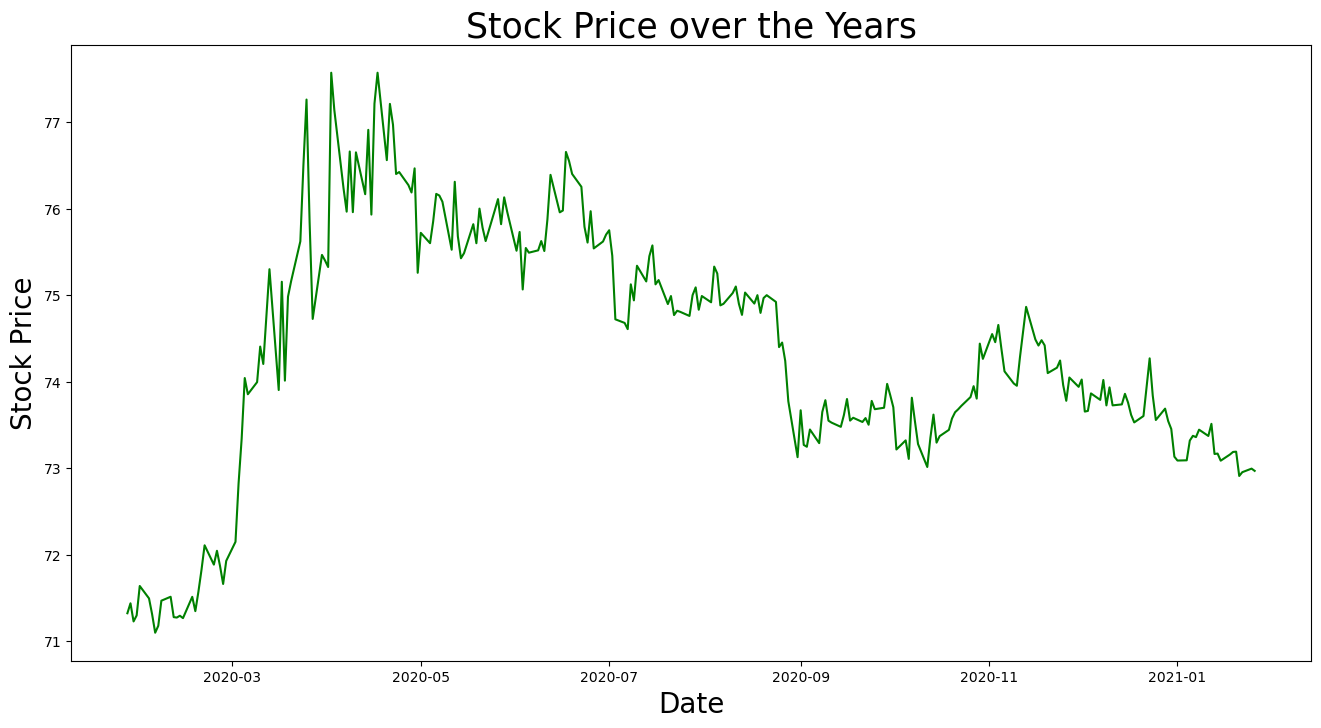

In [13]:
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price over the Years',size=25)

# We will implement  technique of moving average our dataset. The first step is to create a dataframe that contains only the Date and Close price columns, then split it into train and validation sets to verify our predictions.

In [14]:
def moving_avg_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    for i in range(0,valid_set.shape[0]):
        a = train_set['Close'][len(train_set)-valid_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid_set.shape[0])
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set (197, 1)
Shape of Validation Set (65, 1)
RMSE value on validation set: 0.4568039342631442
-----------------------------------------------------------
-----------------------------------------------------------


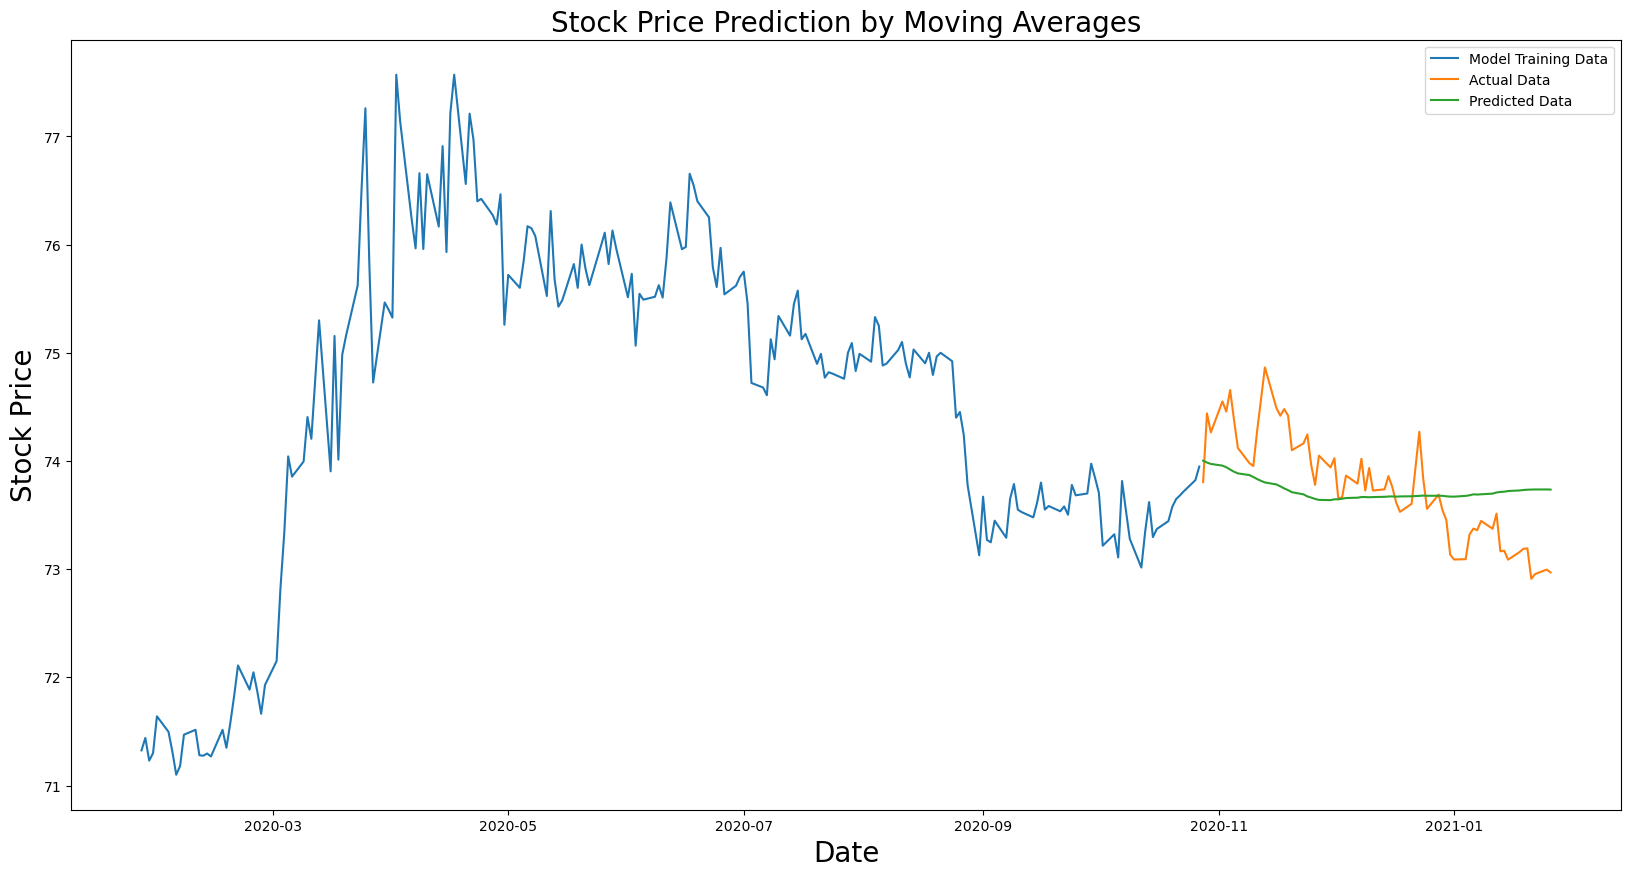

In [15]:
moving_avg_prediction(df)

# Linear Regression

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [16]:
def linear_regression_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------')
    print('-----------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    #implement linear regression
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Linear Regression',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------
-----------------------------------------------------------------
Shape of Training Set (197, 1)
Shape of Validation Set (65, 1)
RMSE value on validation set: 1.1969681153968936
-----------------------------------------------------------
-----------------------------------------------------------


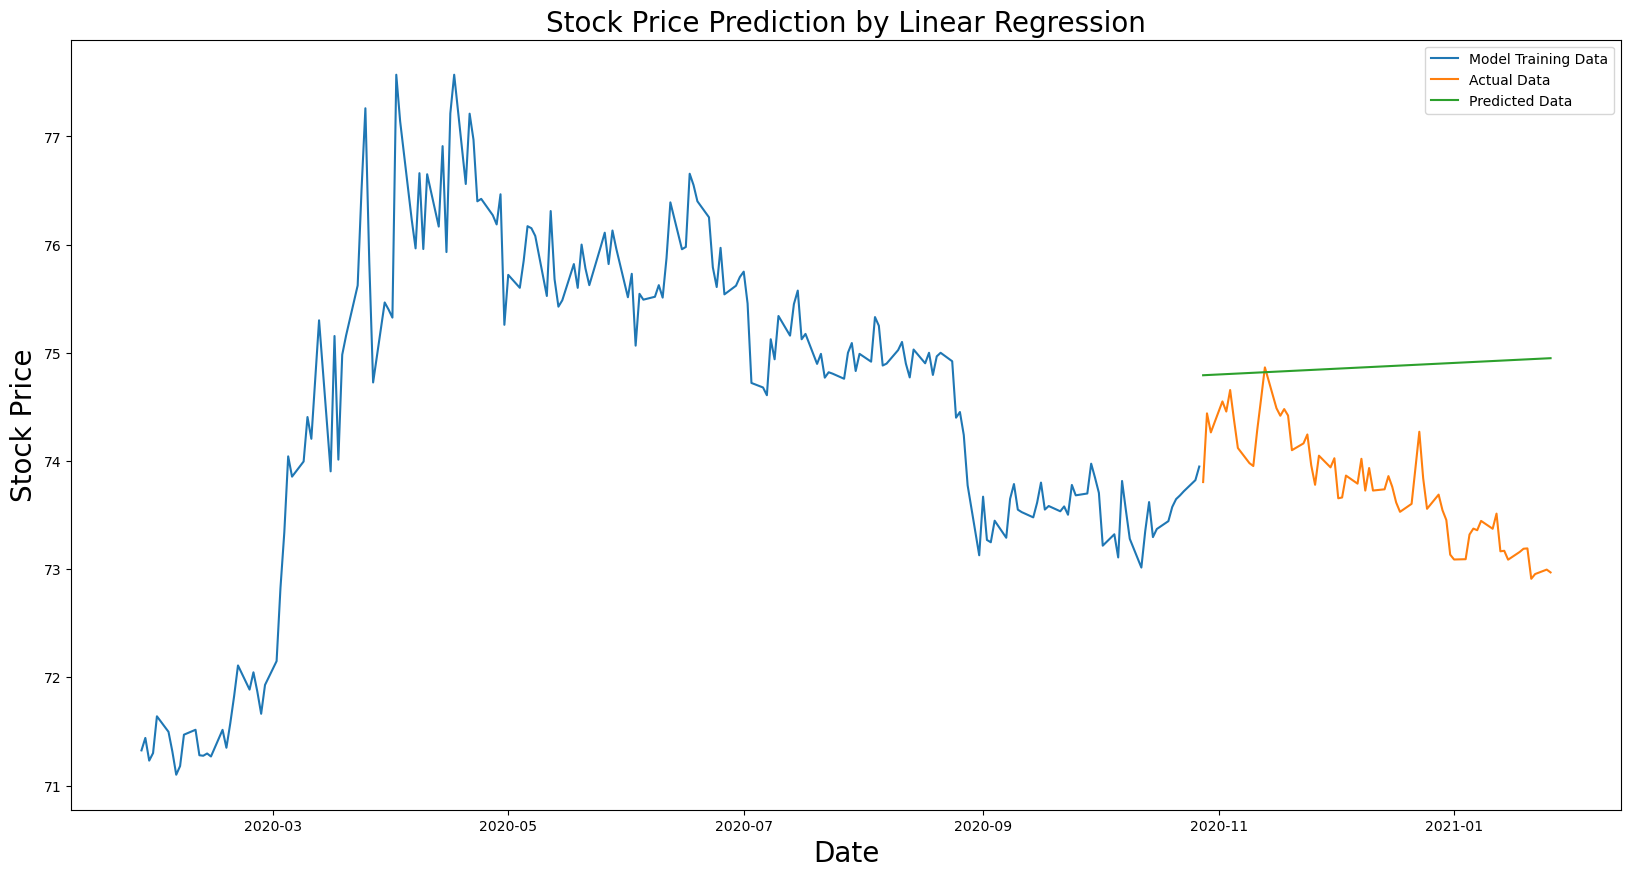

In [17]:
linear_regression_prediction(df)

# K-Nearest Neighbours¶ 

In [19]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('-------------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------
-------------------------------------------------------------------
Shape of Training Set (197, 1)
Shape of Validation Set (65, 1)
RMSE value on validation set: 1.8095025343346032
-----------------------------------------------------------
-----------------------------------------------------------


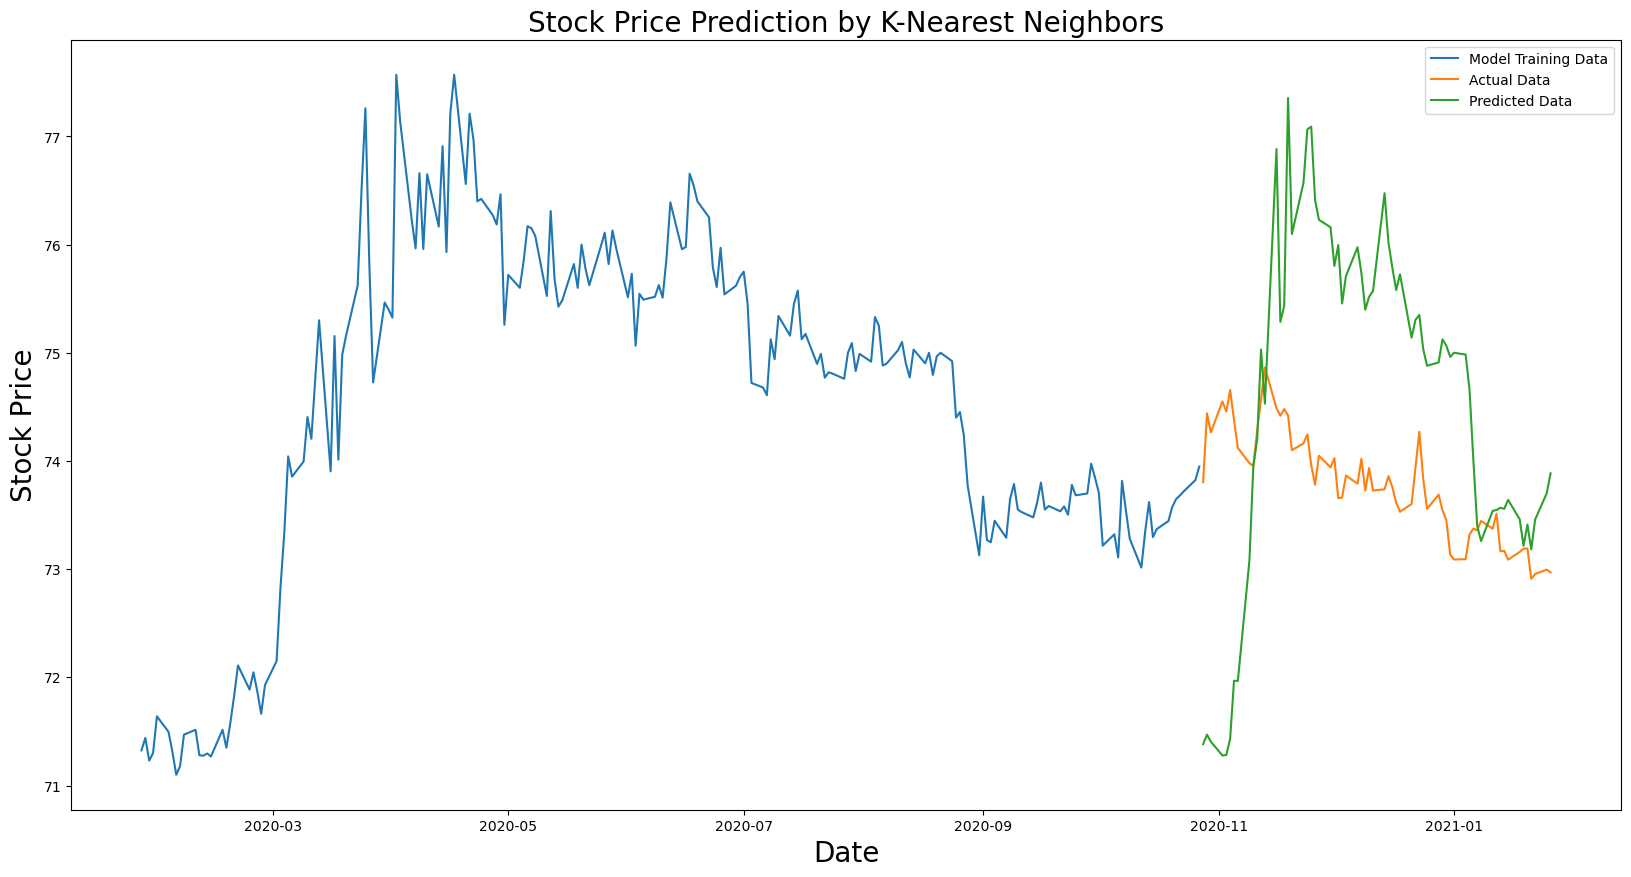

In [20]:
k_nearest_neighbours_predict(df)

# Auto ARIMA

In [21]:
def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Close']
    validation = valid_set['Close']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (197, 7)
Shape of Validation Set (65, 7)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.858, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=294.706, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=359.503, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=286.855, Time=0.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=301.940, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=286.429, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=293.329, Time=0.24 sec
 ARIMA(

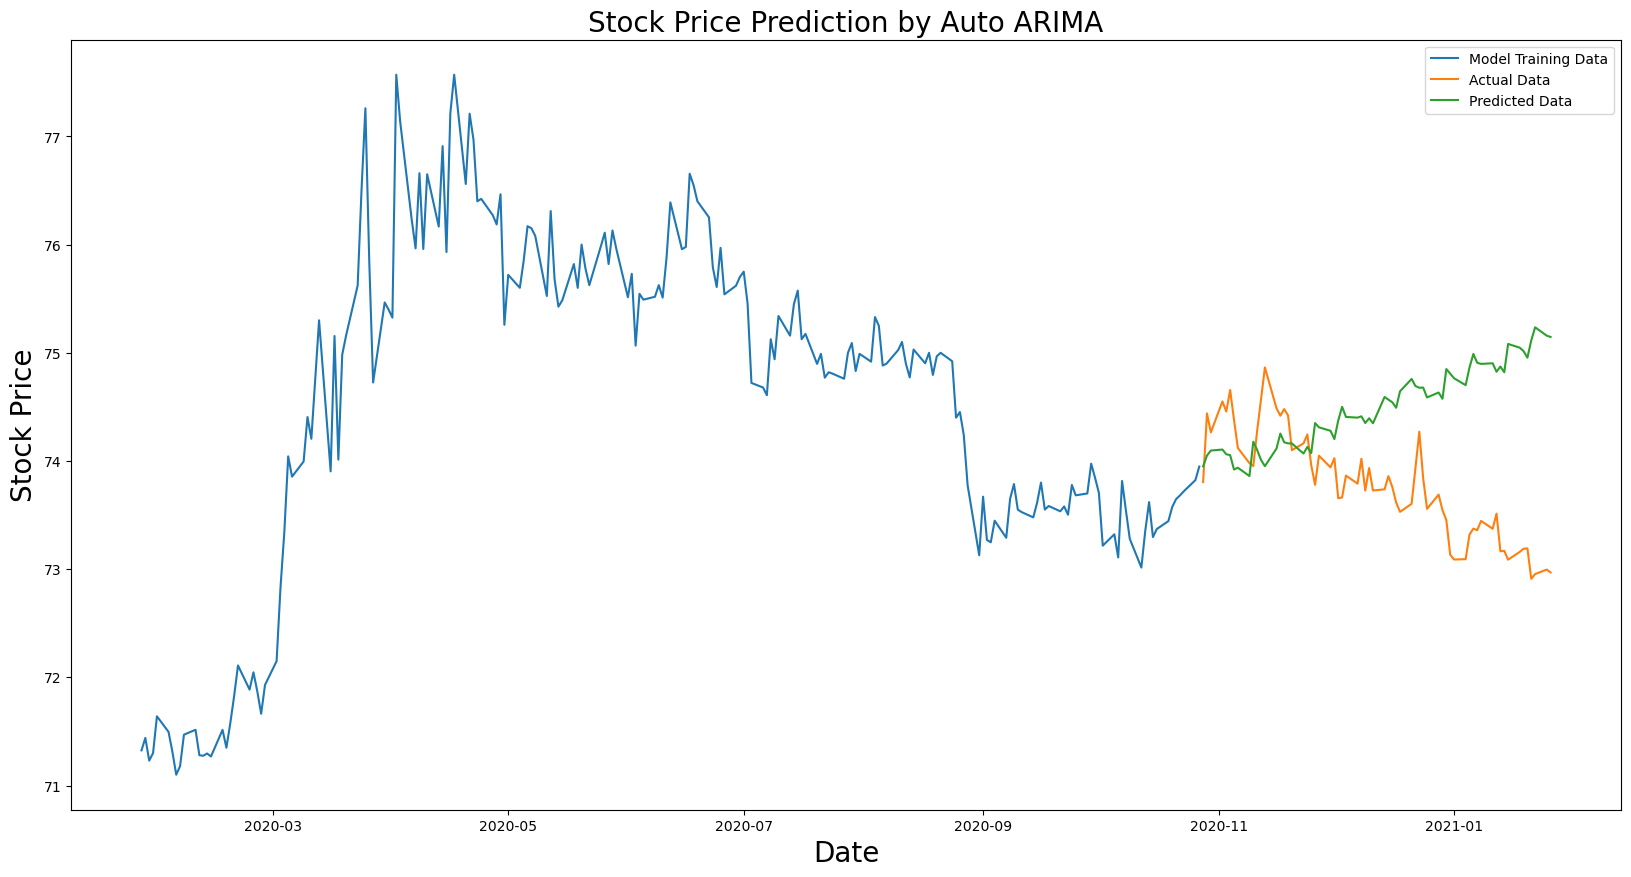

In [22]:
auto_arima_prediction(df)

# Long Short Term Memory (LSTM)

In [23]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (197, 1)
Shape of Validation Set (65, 1)
157/157 - 7s - loss: 0.0223 - 7s/epoch - 45ms/step
3/3 [==============================] - 1s 10ms/step
RMSE value on validation set: Close    0.4309
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


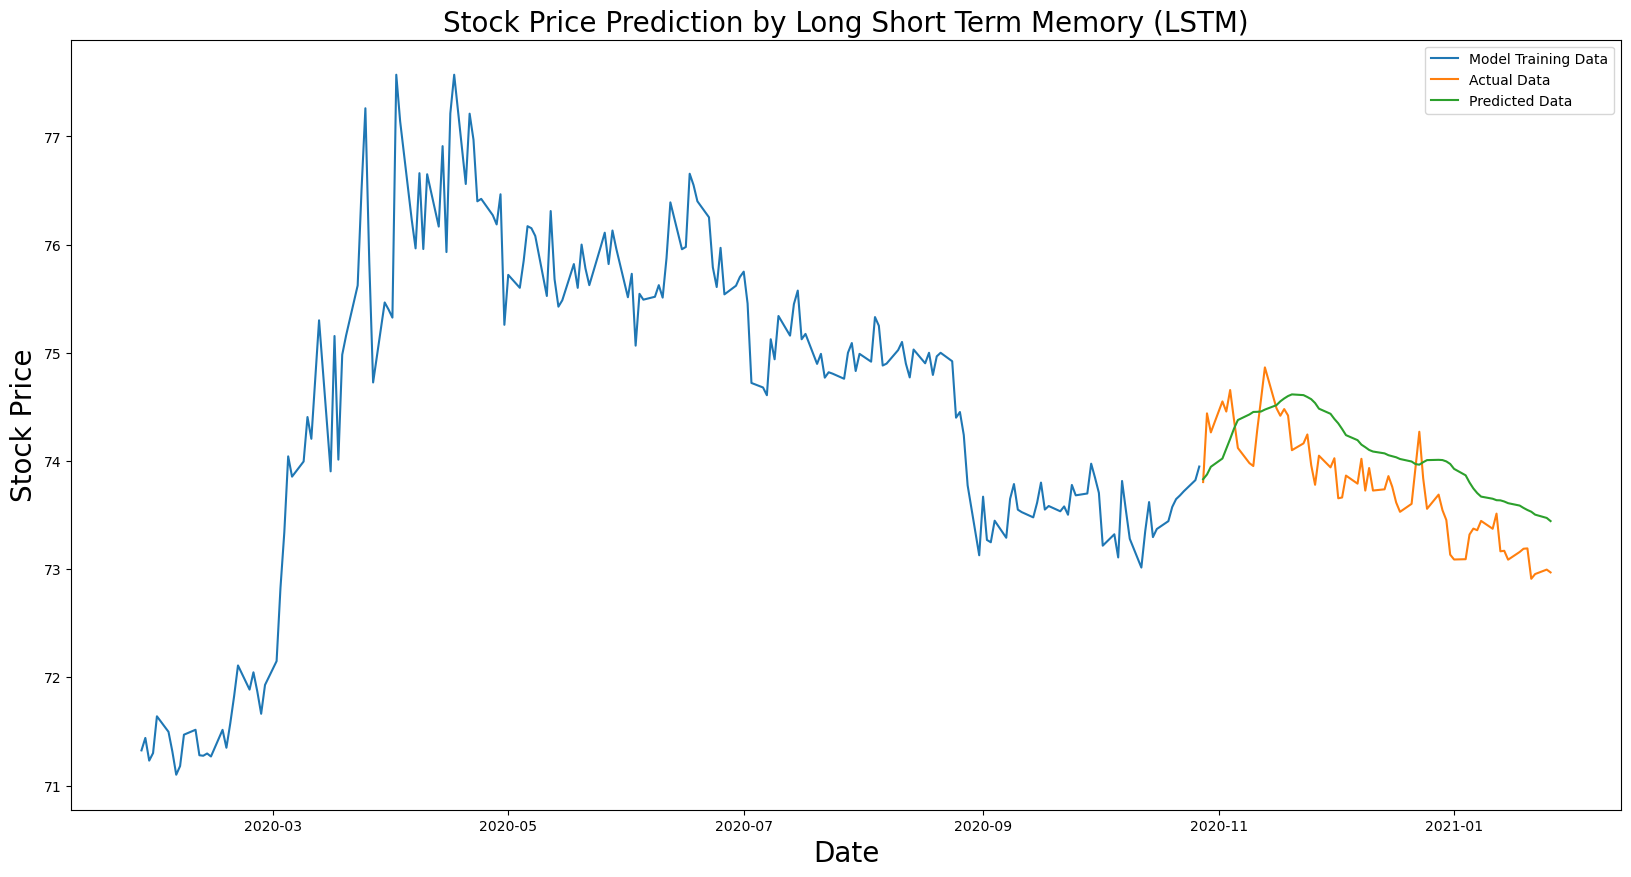

In [24]:
lstm_prediction(df)